In [2]:
# Run the pip install command below if you don't already have the library
# !pip install git+https://github.com/JustAnotherArchivist/snscrape.git

#Sources https://github.com/MartinBeckUT/TwitterScraper/blob/master/snscrape/python-wrapper/snscrape-python-wrapper.ipynb
#https://medium.com/better-programming/how-to-scrape-tweets-with-snscrape-90124ed006af

In [3]:
import pandas as pd
import numpy as np
import re
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.style as style

In [4]:
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

In [5]:
#This controls how many quotes to return
#It looks like 109 is the max amount of quotes I can call at once
# n_quotes = str(109)
# url_link = "https://ron-swanson-quotes.herokuapp.com/v2/quotes"
# ron_swanson_quotes_raw = []
# for i in range(9):
#     temp = requests.get(url_link + '/' + n_quotes)
#     ron_swanson_quotes_raw.append(temp.text)
# len(ron_swanson_quotes_raw)
#The seperator looks like this ","
# ron_quotes = [x for sublist in ron_swanson_quotes_raw for x in sublist.split("\",\"")]
# len(ron_quotes)
# ron_unique = list(set(ron_quotes))
# len(ron_unique)

In [6]:
def scrape_twitter_account(account, start_date, end_date, num_tweets):
    temp_str = 'from:' + account + ' since:' + start_date + ' until:' + end_date
    temp_list = []
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(temp_str).get_items()):
        if i > num_tweets:
            break
        temp_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    return temp_list

In [7]:
#setting the number of tweets I want to return
n_tweets = 3000

#setting what twitter accounts I want to scrape
twitter_accounts = ['AOC', 'SenTedCruz']

#setting time period of tweets to get an accurate comparison
start_date = '2020-01-01'
end_date = '2020-12-01'

# aoc_tweets = scrape_twitter_account(twitter_accounts[0], start_date, end_date, n_tweets)
# cruz_tweets = scrape_twitter_account(twitter_accounts[1], start_date, end_date, n_tweets)

In [8]:
# Creating a dataframe from the tweets list above
# aoc_df = pd.DataFrame(aoc_tweets, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])
# cruz_df = pd.DataFrame(cruz_tweets, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

# print(aoc_df.shape)
# print(cruz_df.shape)

In [9]:
# aoc_df['Month'] = aoc_df['Datetime'].dt.month
# cruz_df['Month'] = cruz_df['Datetime'].dt.month

In [10]:
#Saving the dataframes as csv so I dont have to scrape everytime
# aoc_df.to_csv(r"C:\Users\cherndon\python_practice\Final Project\aoc tweets.csv")
# cruz_df.to_csv(r"C:\Users\cherndon\python_practice\Final Project\cruz tweets.csv")

In [11]:
aoc_df = pd.read_csv(r"C:\Users\cherndon\python_practice\Final Project\aoc tweets.csv")
cruz_df = pd.read_csv(r"C:\Users\cherndon\python_practice\Final Project\cruz tweets.csv")

---

# **Exploratory Data Analysis**

In [18]:
print("AOC's average number of tweets per month was {0:.0f}".format(aoc_df.groupby('Month')['Tweet Id'].count().mean()))
print("Ted Cruz'z average number of tweets per month was {0:.0f}".format(cruz_df.groupby('Month')['Tweet Id'].count().mean()))

AOC's average number of tweets per month was 119
Ted Cruz'z average number of tweets per month was 237


Text(0.5, 1.0, 'AOC Number of Tweets per Month')

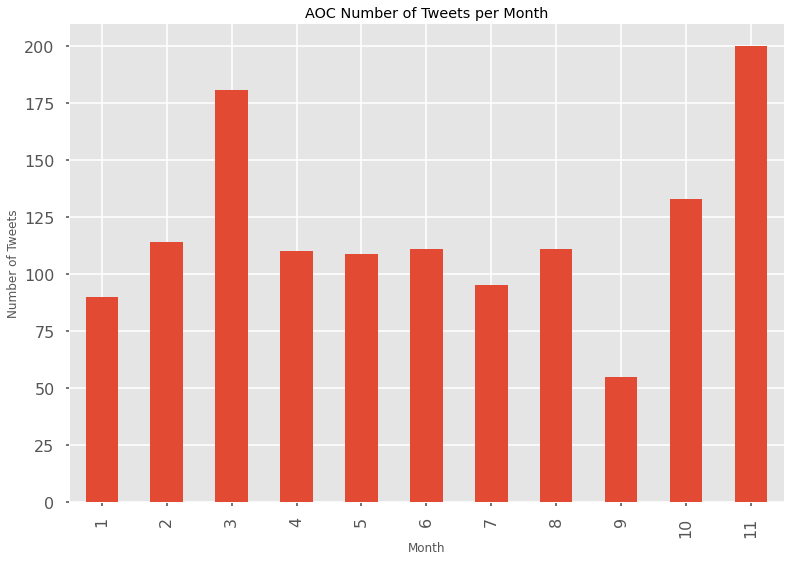

In [12]:
aoc_df.groupby('Month')['Tweet Id'].count().plot.bar()
plt.ylabel('Number of Tweets')
plt.title("AOC Number of Tweets per Month")

Text(0.5, 1.0, 'Cruz Number of Tweets per Month')

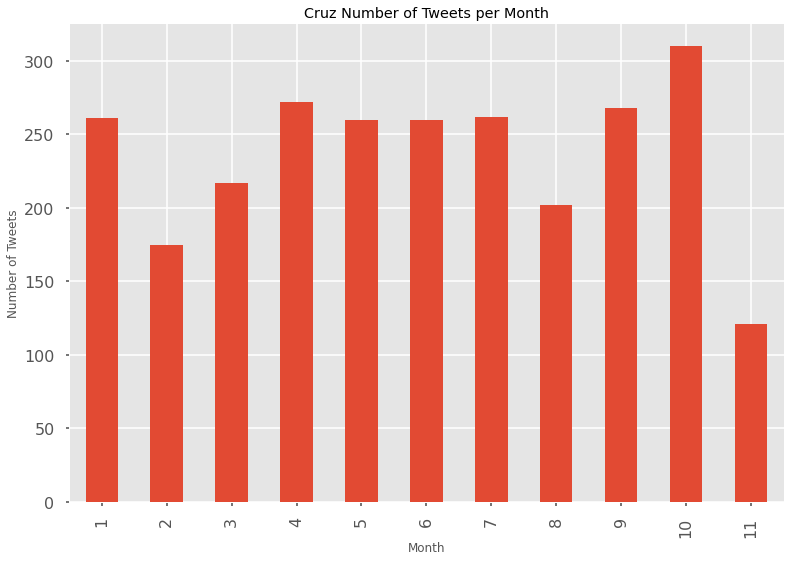

In [13]:
cruz_df.groupby('Month')['Tweet Id'].count().plot.bar()
plt.ylabel('Number of Tweets')
plt.title("Cruz Number of Tweets per Month")

In [23]:
tweets = ['@joe123 thank you!', 'this reminds me of ?$%$ @john12', 'this tweet ha%s no use&rname \n tag in it']

clean_tweets = [word for tweet in tweets for word in tweet.split() if not word.startswith('@')]

In [24]:
[re.sub(r'\s*@\w+\s*', '', x) for x in tweets]

['thank you!',
 'this reminds me of ?$%$',
 'this tweet ha%s no use&rname \n tag in it']

In [26]:
from nltk import wordpunct_tokenize, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

In [29]:
sw = stopwords.words('english')
wn = WordNetLemmatizer()
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

In [36]:
[tknzr.tokenize(x) for x in tweets]

[['thank', 'you', '!'],
 ['this', 'reminds', 'me', 'of', '?', '$', '%', '$'],
 ['this',
  'tweet',
  'ha',
  '%',
  's',
  'no',
  'use',
  '&',
  'rname',
  'tag',
  'in',
  'it']]

In [20]:
?wordpunct_tokenize

Signature: wordpunct_tokenize(text)
Docstring:
Return a tokenized copy of *s*.

:rtype: list of str
File:      c:\users\cherndon\anaconda3\envs\data\lib\site-packages\nltk\tokenize\regexp.py
Type:      method


In [ ]:
[re.sub(r'@\w+', '', x) for x in tweets]

In [ ]:
def clean_tweets(x):
    x = x.lower()